In [5]:
import numpy as np
import os
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import h5py

#### 1) Open $C^*$ values (in mmol/m$^3$) for all years (1992-2022) and store them as a stacked array.

For each year, $C^*(x,y,z)$ is on a regular (lat, lon, depth) grid with $(180, 360, 50)$ grid points.

In [7]:
data_folder = "../raw_Cstar_data/"
years = list(range(1992, 2023))  #31 years: 1992 to 2022
cstar_stack = []

#Load each year's file and append to list
for y in years:
    path = os.path.join(data_folder, f"cstar_interp_{y}.h5")
    with h5py.File(path, 'r') as f:
        cstar = f['Cstar'][:] # Use [:] to load data into memory
    cstar_stack.append(cstar)

#Stack
cstar_all = np.stack(cstar_stack, axis=-1)         
print('Shape of stacked array (lat, lon, depth, years): ', cstar_all.shape)

Shape of stacked array (lat, lon, depth, years):  (180, 360, 50, 31)


In [12]:
# Load \Delta z (vertical grid spacing)
drf_path = "../processed_data/DRF.data" 
drf = np.fromfile(drf_path, dtype='>f4')[:50]

# Load area for each grid point
with h5py.File('../processed_data/area_volume.h5', 'r') as f:
    area = f['Area'][:]

#### 2) Compute timeseries of globally-integrated $C^*$

- globally-integrated $C^*$ ($\langle C^*\rangle$) 

- annual rate of change of globally-integrated $C^*$ ($\Delta \langle C^*\rangle$) 

In [20]:
# Compute globally-integrated C^* for each year

Cstar_timeseries = np.zeros((31,))

for ind in range(31):
    # convert to Pg C by multiply: (mmol/m^3)*(m^3)*(1 mol/1000 mmol)*(12 g/mol)
    Cstar_timeseries[ind] = (12/1000)*np.nansum(cstar_all[:, :, :, ind]*area*drf)/1e15

In [22]:
# Compute annual rate of change of globally-integrated C^* for each year

dCstar_timeseries = Cstar_timeseries[1:]-Cstar_timeseries[:-1]

In [25]:
# Save data as HDF5
with h5py.File('../processed_data/global_Cstar_timeseries.h5', 'w') as f:
    dset = f.create_dataset('Cstar_1992_2022', data=Cstar_timeseries)
    f.create_dataset('dCstar_1993_2022', data=dCstar_timeseries)
    f['Cstar_1992_2022'].attrs['unit'] = 'Pg C'
    f['dCstar_1993_2022'].attrs['unit'] = 'Pg C/yr'
    f.create_dataset('time', data=years)

#### 3) Reproduce manuscript figure

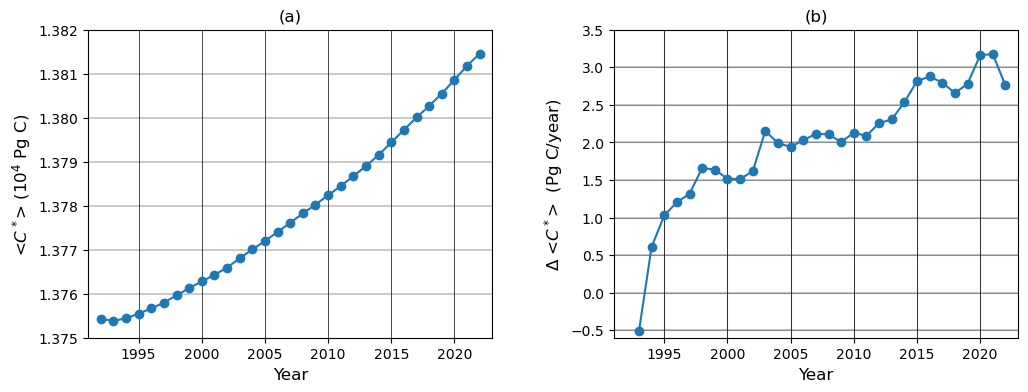

In [28]:
time = np.arange(1992, 2023)
yrs = np.arange(1995, 2022, 5)

fig, axs = plt.subplots(1, 2)
ax = axs[0]
for ind in range(len(yrs)):
    ax.plot(yrs[ind]*np.ones((50,)), np.linspace((Cstar_timeseries[0]-10)/1e4, (Cstar_timeseries[-1]+10)/1e4),
         'k', lw=0.5)
ax.plot(np.linspace(1991, 2023), 1.376*np.ones((50,)), 'k', lw=0.3)
ax.plot(np.linspace(1991, 2023), 1.377*np.ones((50,)), 'k', lw=0.3)
ax.plot(np.linspace(1991, 2023), 1.378*np.ones((50,)), 'k', lw=0.3)
ax.plot(np.linspace(1991, 2023), 1.379*np.ones((50,)), 'k', lw=0.3)
ax.plot(np.linspace(1991, 2023), 1.380*np.ones((50,)), 'k', lw=0.3)
ax.plot(np.linspace(1991, 2023), 1.381*np.ones((50,)), 'k', lw=0.3)
ax.plot(np.linspace(1991, 2023), 1.382*np.ones((50,)), 'k', lw=0.3)
ax.plot(time, (Cstar_timeseries)/1e4, '-o')
ax.set_xlim([1991, 2023])
ax.set_ylim([1.375, 1.382])
ax.set(xlabel = 'Year', ylabel = '<$C^*$> ($10^4$ Pg C)', title='(a)')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(12)

ax = axs[1]
ax.set(xlabel = 'Year', ylabel = r'$\Delta$ <$C^*$>  (Pg C/year)', title='(b)')
for ind in range(len(yrs)):
    ax.plot(yrs[ind]*np.ones((50,)), np.linspace(-0.6, 3.5),
         'k', lw=0.5)
ax.plot(np.linspace(1991, 2023), -0.5*np.ones((50,)), 'k', lw=0.3)
ax.plot(np.linspace(1991, 2023), 0*np.ones((50,)), 'k', lw=0.3)
ax.plot(np.linspace(1991, 2023), 0.5*np.ones((50,)), 'k', lw=0.3)
ax.plot(np.linspace(1991, 2023), np.ones((50,)), 'k', lw=0.3)
ax.plot(np.linspace(1991, 2023), 1.5*np.ones((50,)), 'k', lw=0.3)
ax.plot(np.linspace(1991, 2023), 2*np.ones((50,)), 'k', lw=0.3)
ax.plot(np.linspace(1991, 2023), 2.5*np.ones((50,)), 'k', lw=0.3)
ax.plot(np.linspace(1991, 2023), 3*np.ones((50,)), 'k', lw=0.3)
ax.plot(time[1:], Cstar_timeseries[1:]-Cstar_timeseries[:-1], '-o')
ax.set_xlim([1991, 2023])
ax.set_ylim([-0.6, 3.5])
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(12)
ax.grid()


fig.set_size_inches(12, 4)
fig.subplots_adjust(wspace=0.3)
fig.savefig("../figures/global_Cstar_timeseries.png", dpi=600, bbox_inches='tight')